In [3]:
import os
import pandas as pd
import pm4py

Data Loading:

In [4]:
file_dir = '../data/'
file_name = 'Hospital_Billing_Eventlog.xes'
download_url = 'https://data.4tu.nl/file/6af6d5f0-f44c-49be-aac8-8eaa5fe4f6fd/28b83e72-375e-4da4-8459-a8506e898edf'
# Check if file exists and download it if not

# Check if directory exists
if not os.path.exists(file_dir):
    os.system("mkdir " + file_dir)
if not os.path.exists(file_dir + file_name):
    print('Downloading file...')
    os.system(f'wget -O {file_dir + file_name + ".gz"} {download_url}')
    os.system(f'gzip -d {file_dir + file_name + ".gz"}')


In [6]:
data = pm4py.read_xes(file_dir + file_name)
data = pm4py.format_dataframe(data)

NameError: name 'file_dir' is not defined

In [5]:
# Get overview over data
data

NameError: name 'data' is not defined

Preprocessing:

In [4]:
# print columns
data = data[['@@case_index', 'diagnosis', 'concept:name', 'isCancelled', 'isClosed']]
data

NameError: name 'data' is not defined

In [7]:
# Save as new, smaller csv
data.to_csv('../data/preprocessed_data.csv', sep=';', index=False)

NameError: name 'data' is not defined

Feature Extraction:

In [8]:
# Overview over unique values for each column
data = pd.read_csv('../data/preprocessed_data.csv', sep=';')
print("Unique value oveview:\n")
print("======================")
print(data.nunique())
print("======================")
unique_states = data["concept:name"].unique()

Unique value oveview:

@@case_index    100000
diagnosis         1191
concept:name        18
isCancelled          2
isClosed             2
dtype: int64


# Full Data extraction

In [22]:
# Get traces
full_data = pm4py.read_xes("../data/Hospital_Billing_Eventlog.xes")

traces = full_data.groupby('case:concept:name')['concept:name'].apply(tuple).reset_index().rename(columns={'case:concept:name': 'case_id', 'concept:name': 'trace'})

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 100000/100000 [00:34<00:00, 2880.66it/s]


In [10]:
traces

,@@case_index,Traces
0,0,"(NEW, FIN, RELEASE, CODE OK, BILLED)"
1,1,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
2,2,"(NEW,)"
3,3,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
4,4,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
...,...,...
99995,99995,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
99996,99996,"(NEW, DELETE)"
99997,99997,"(NEW, CHANGE DIAGN, DELETE)"
99998,99998,"(NEW,)"


In [24]:
# Get the value counts for each unique trace
trace_counts = traces['trace'].value_counts()

# Convert to dictionary
trace_counts_dict = trace_counts.to_dict()

In [26]:
len(trace_counts_dict)
trace_counts_dict

{('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 33673,
 ('NEW',): 22373,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 20902,
 ('NEW', 'DELETE'): 4813,
 ('NEW', 'FIN'): 3508,
 ('NEW',
  'CHANGE DIAGN',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 2121,
 ('NEW', 'CHANGE DIAGN', 'DELETE'): 1555,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'BILLED'): 977,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 869,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'CODE OK'): 512,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'EMPTY'): 400,
 ('NEW', 'FIN', 'RELEASE', 'BILLED'): 359,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT',
  'BILLED'): 314,
 ('NEW',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 273,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT


### OneHotEncoding & Hamming Distance 
1. Getting Unique pages and trace_count_dict as dataframe
2. MultiLabelBinarizer (left side classes for a matrix are unique Page Names) -> OneHotEncoding
3. If weighted enabled -> OneHot encoded matrix multiplied with count of traces
4. Hamming Distance between all traces into Matrix (based on one_hot_df)
5. Saving hammming Dataframe (matrix) as csv 



In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial.distance import pdist, squareform, hamming
import numpy as np




df = pd.DataFrame(list(trace_counts_dict.items()), columns=['Traces', 'Count'])

mlb = MultiLabelBinarizer()

one_hot_encoded = mlb.fit_transform(df['Traces'])


one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
#one_hot_df.to_csv('../data/onehot_df.csv', sep=';', index=False)

print(one_hot_encoded[0])
#print(hamming(one_hot_encoded[0], one_hot_encoded[1]))

use_weighted = False
if use_weighted:
    weighted_one_hot_encoded = one_hot_encoded * df['Count'].values[:, None]
    print(weighted_one_hot_encoded[0])
    weighted_one_hot_df = pd.DataFrame(weighted_one_hot_encoded, columns=mlb.classes_)
else:
    weighted_one_hot_df = one_hot_df

hamming_distances = pdist(weighted_one_hot_df, metric='hamming')
hamming_matrix = squareform(hamming_distances)
hamming_matrix_df = pd.DataFrame(hamming_matrix, index=df['Traces'], columns=df['Traces'])

print(hamming_matrix_df)
#hamming_matrix_df.to_csv('../data/hamming_matrix_df.csv', sep=';', index=False)

[1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0]
Traces                                              (NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BILLED)  \
Traces                                                                                                   
(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BILLED)                                           0.000000    
(NEW,)                                                                                       0.277778    
(NEW, FIN, RELEASE, CODE OK, BILLED)                                                         0.055556    
(NEW, DELETE)                                                                                0.333333    
(NEW, FIN)                                                                                   0.222222    
...                                                                                               ...    
(NEW, FIN, RELEASE, CODE NOK, CODE OK, BILLED, ...                                           0.333333    
(NEW, CH


### Clustering Algorithm K-Means:
1. Clustering of Traces based on Hamming Distance Dataframe with K-Means

In [28]:
from sklearn.cluster import KMeans
num_clusters = 2


kmeans = KMeans(n_clusters=num_clusters, random_state=12345, n_init=20)
kmeans.fit(hamming_matrix_df)


df['Cluster'] = kmeans.labels_
df_sorted = df.sort_values(by='Cluster')

df_sorted.to_csv('../data/clustered_traces_onehot_kmeans.csv', index=False)

cluster_sizes = df_sorted['Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} Traces")

Cluster 0: 288 Traces
Cluster 1: 732 Traces


### Evaluation:
- Silhouette Coefficient: distance between the clusters 


In [29]:
from sklearn.metrics import silhouette_score,silhouette_samples

silhouette_avg = silhouette_score(hamming_matrix_df, kmeans.labels_)
print(f"Silhouette Coefficient AVG: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(hamming_matrix_df, kmeans.labels_)
for i in range(num_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    print(f"Silhouette Coefficient for cluster {i}: {np.mean(ith_cluster_silhouette_values)}")

Silhouette Coefficient AVG: 0.3825848433988767
Silhouette Coefficient for cluster 0: 0.31668705017858834
Silhouette Coefficient for cluster 1: 0.4085118440101377


### Visualization:

- Using TSNE to visualize results

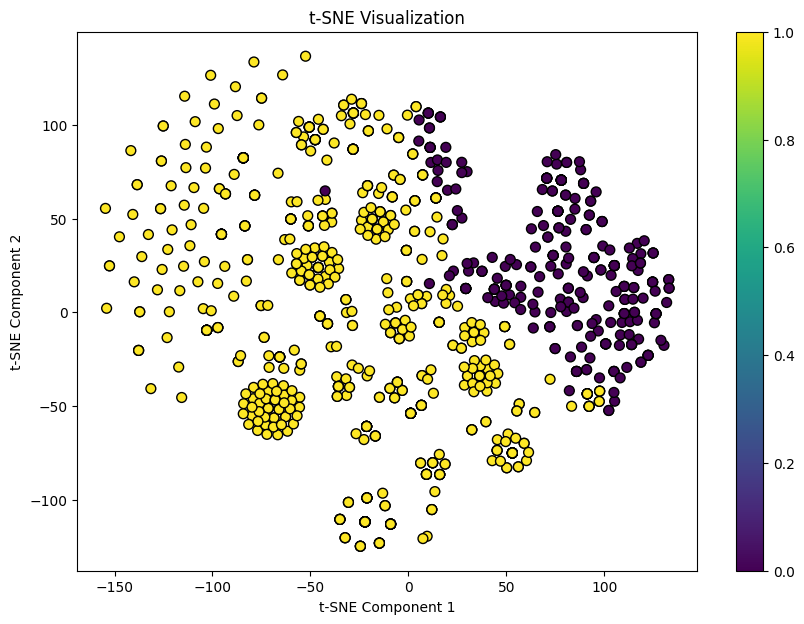

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, perplexity=50, max_iter=1000)
tsne_result = tsne.fit_transform(hamming_matrix_df)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()


### Postprocessing: Petri-Net for every Cluster 


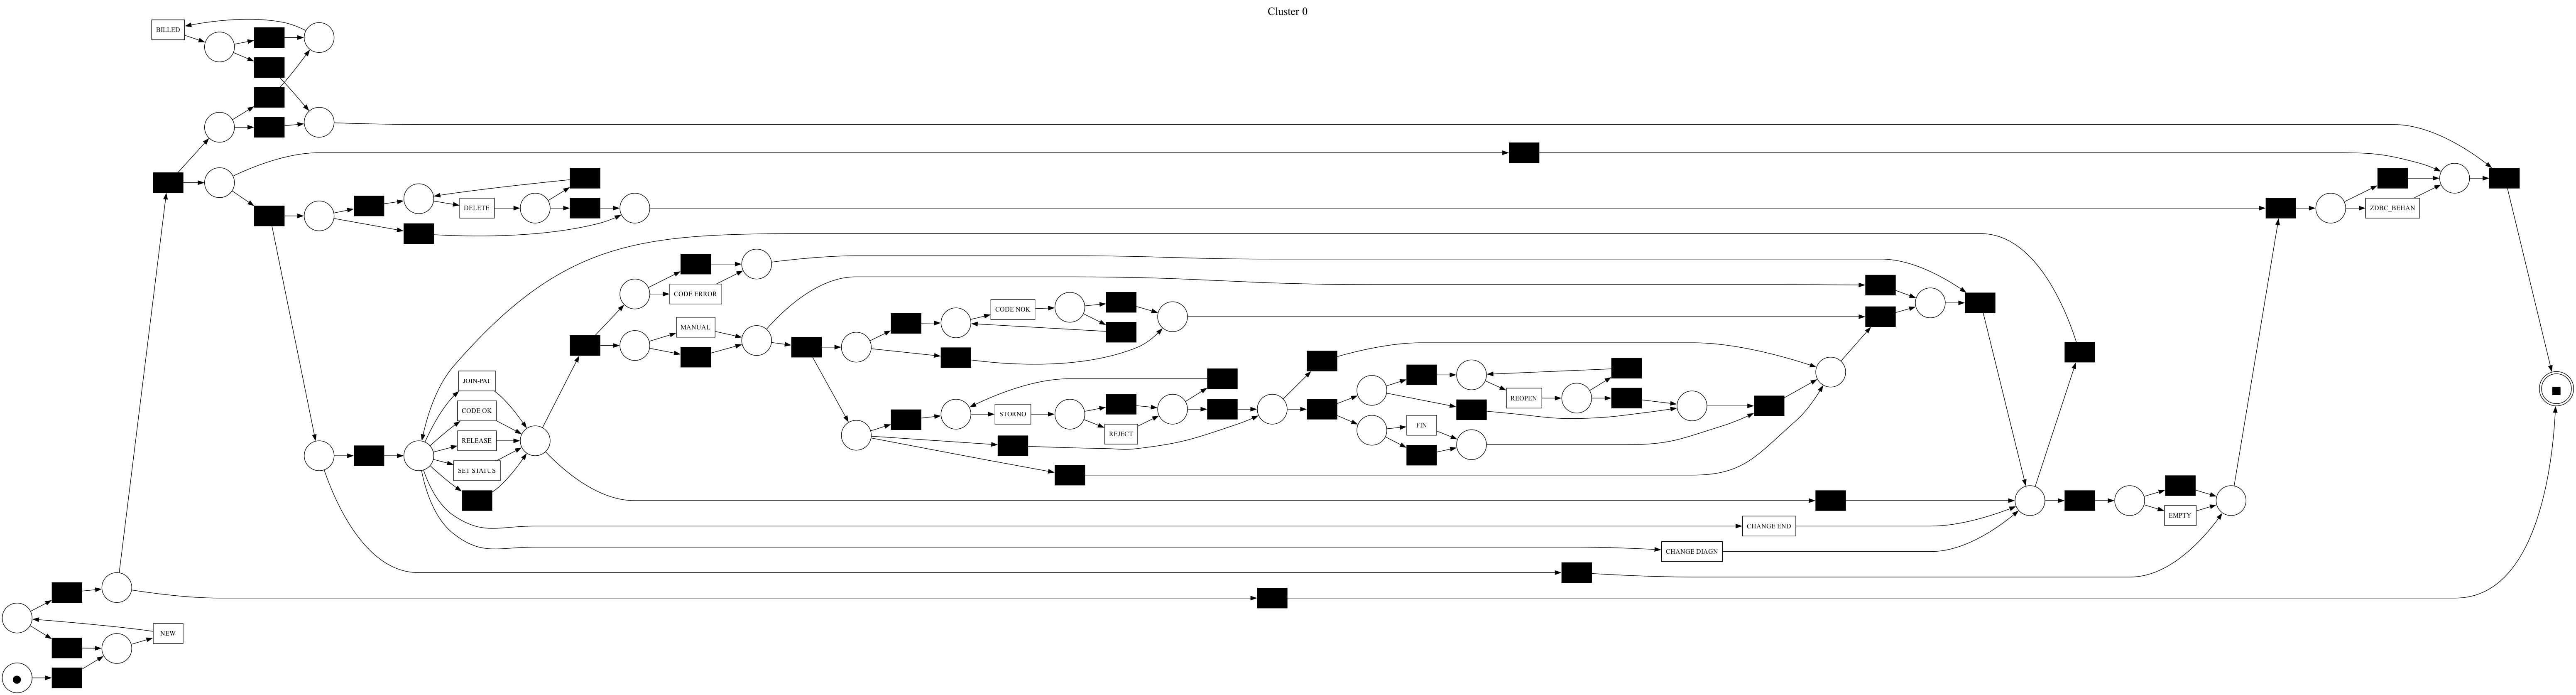

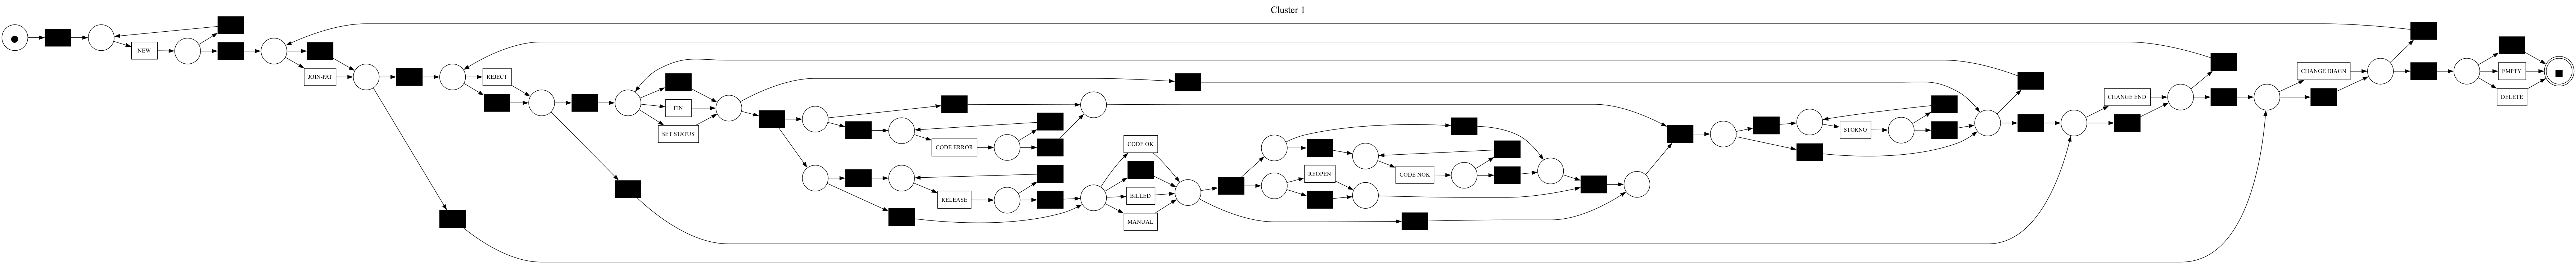

In [31]:
import pm4py
import pandas as pd
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.visualization.petri_net import visualizer as pm4pyvis

def create_event_log(traces):
    log = EventLog()
    for trace_tuple in traces:
        trace = Trace()
        for event_name in trace_tuple:
            event = Event({"concept:name": event_name})
            trace.append(event)
        log.append(trace)
    return log


clusters = df_sorted.groupby('Cluster')

for cluster_id, group in clusters:
    traces = group['Traces'].repeat(group['Count']).tolist()
    event_log = create_event_log(traces)
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
    gviz = pm4pyvis.apply(net, initial_marking, final_marking)
    gviz.graph_attr['label'] = f'Cluster {cluster_id}'
    gviz.graph_attr['labelloc'] = 't'
    gviz.graph_attr['fontsize'] = '20'
    pm4pyvis.view(gviz)